In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
def sample(buffer, batch_size):
    idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
    return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:1.3916 dloss:0.8886 aloss2:0.3818 exploreP:0.9984
Episode:1 meanR:22.5000 R:29.0000 rate:0.0580 aloss:1.3859 dloss:0.8714 aloss2:0.4165 exploreP:0.9956
Episode:2 meanR:21.6667 R:20.0000 rate:0.0400 aloss:1.3847 dloss:0.8646 aloss2:0.4367 exploreP:0.9936
Episode:3 meanR:28.2500 R:48.0000 rate:0.0960 aloss:1.3850 dloss:0.8483 aloss2:0.4685 exploreP:0.9889
Episode:4 meanR:24.8000 R:11.0000 rate:0.0220 aloss:1.3797 dloss:0.8331 aloss2:0.4998 exploreP:0.9878
Episode:5 meanR:23.6667 R:18.0000 rate:0.0360 aloss:1.3829 dloss:0.8255 aloss2:0.5294 exploreP:0.9860
Episode:6 meanR:23.1429 R:20.0000 rate:0.0400 aloss:1.3859 dloss:0.8311 aloss2:0.5122 exploreP:0.9841
Episode:7 meanR:25.1250 R:39.0000 rate:0.0780 aloss:1.3803 dloss:0.8049 aloss2:0.5829 exploreP:0.9803
Episode:8 meanR:26.4444 R:37.0000 rate:0.0740 aloss:1.3814 dloss:0.7913 aloss2:0.6381 exploreP:0.9767
Episode:9 meanR:26.0000 R:22.0000 rate:0.0440 aloss:1.3819 dloss:0.7899 aloss2:0.6

Episode:80 meanR:28.2840 R:62.0000 rate:0.1240 aloss:1.3786 dloss:0.4206 aloss2:6.8057 exploreP:0.7973
Episode:81 meanR:28.0610 R:10.0000 rate:0.0200 aloss:1.3710 dloss:0.3853 aloss2:7.1404 exploreP:0.7965
Episode:82 meanR:28.0000 R:23.0000 rate:0.0460 aloss:1.3631 dloss:0.4078 aloss2:7.2651 exploreP:0.7947
Episode:83 meanR:28.5952 R:78.0000 rate:0.1560 aloss:1.3711 dloss:0.4173 aloss2:7.3462 exploreP:0.7886
Episode:84 meanR:28.4118 R:13.0000 rate:0.0260 aloss:1.3656 dloss:0.4033 aloss2:7.1611 exploreP:0.7876
Episode:85 meanR:28.4535 R:32.0000 rate:0.0640 aloss:1.3661 dloss:0.3930 aloss2:7.5071 exploreP:0.7851
Episode:86 meanR:28.4368 R:27.0000 rate:0.0540 aloss:1.3686 dloss:0.4147 aloss2:7.9609 exploreP:0.7830
Episode:87 meanR:28.6364 R:46.0000 rate:0.0920 aloss:1.3679 dloss:0.3930 aloss2:7.8797 exploreP:0.7795
Episode:88 meanR:28.8989 R:52.0000 rate:0.1040 aloss:1.3714 dloss:0.4019 aloss2:7.7332 exploreP:0.7755
Episode:89 meanR:29.3000 R:65.0000 rate:0.1300 aloss:1.3710 dloss:0.4074 

Episode:159 meanR:46.6500 R:73.0000 rate:0.1460 aloss:1.3692 dloss:0.3974 aloss2:8.2599 exploreP:0.5413
Episode:160 meanR:47.1200 R:77.0000 rate:0.1540 aloss:1.3666 dloss:0.3986 aloss2:8.0766 exploreP:0.5372
Episode:161 meanR:47.1900 R:37.0000 rate:0.0740 aloss:1.3629 dloss:0.3874 aloss2:8.1262 exploreP:0.5353
Episode:162 meanR:48.7900 R:178.0000 rate:0.3560 aloss:1.3638 dloss:0.3899 aloss2:8.1934 exploreP:0.5260
Episode:163 meanR:49.4800 R:110.0000 rate:0.2200 aloss:1.3643 dloss:0.3843 aloss2:8.3019 exploreP:0.5204
Episode:164 meanR:50.3200 R:112.0000 rate:0.2240 aloss:1.3626 dloss:0.3911 aloss2:8.1853 exploreP:0.5147
Episode:165 meanR:50.6800 R:61.0000 rate:0.1220 aloss:1.3650 dloss:0.3814 aloss2:8.2850 exploreP:0.5116
Episode:166 meanR:51.5900 R:128.0000 rate:0.2560 aloss:1.3656 dloss:0.3884 aloss2:8.2997 exploreP:0.5052
Episode:167 meanR:51.7600 R:83.0000 rate:0.1660 aloss:1.3652 dloss:0.3796 aloss2:8.2492 exploreP:0.5011
Episode:168 meanR:52.2400 R:68.0000 rate:0.1360 aloss:1.3680

Episode:238 meanR:118.7400 R:162.0000 rate:0.3240 aloss:1.3646 dloss:0.4663 aloss2:6.4446 exploreP:0.1980
Episode:239 meanR:119.9100 R:145.0000 rate:0.2900 aloss:1.3616 dloss:0.4517 aloss2:6.6302 exploreP:0.1953
Episode:240 meanR:123.5200 R:491.0000 rate:0.9820 aloss:1.3657 dloss:0.4692 aloss2:6.5359 exploreP:0.1865
Episode:241 meanR:124.4300 R:116.0000 rate:0.2320 aloss:1.3655 dloss:0.4502 aloss2:6.4864 exploreP:0.1844
Episode:242 meanR:129.2600 R:500.0000 rate:1.0000 aloss:1.3644 dloss:0.4606 aloss2:6.5297 exploreP:0.1759
Episode:243 meanR:130.0800 R:226.0000 rate:0.4520 aloss:1.3641 dloss:0.4910 aloss2:6.4702 exploreP:0.1722
Episode:244 meanR:132.2600 R:234.0000 rate:0.4680 aloss:1.3657 dloss:0.4702 aloss2:6.4597 exploreP:0.1685
Episode:245 meanR:133.8000 R:194.0000 rate:0.3880 aloss:1.3613 dloss:0.4829 aloss2:6.3502 exploreP:0.1654
Episode:246 meanR:135.0000 R:168.0000 rate:0.3360 aloss:1.3648 dloss:0.4637 aloss2:6.2775 exploreP:0.1628
Episode:247 meanR:135.0700 R:69.0000 rate:0.13

Episode:316 meanR:259.2800 R:454.0000 rate:0.9080 aloss:1.3365 dloss:0.5413 aloss2:4.1921 exploreP:0.0319
Episode:317 meanR:259.6200 R:220.0000 rate:0.4400 aloss:1.3295 dloss:0.5379 aloss2:3.8952 exploreP:0.0314
Episode:318 meanR:261.9900 R:500.0000 rate:1.0000 aloss:1.3341 dloss:0.5323 aloss2:4.0178 exploreP:0.0303
Episode:319 meanR:265.9500 R:500.0000 rate:1.0000 aloss:1.3290 dloss:0.5467 aloss2:3.7856 exploreP:0.0294
Episode:320 meanR:266.6100 R:219.0000 rate:0.4380 aloss:1.3314 dloss:0.5638 aloss2:3.7366 exploreP:0.0289
Episode:321 meanR:270.2800 R:500.0000 rate:1.0000 aloss:1.3290 dloss:0.5363 aloss2:3.7466 exploreP:0.0280
Episode:322 meanR:272.5600 R:367.0000 rate:0.7340 aloss:1.3237 dloss:0.5581 aloss2:3.6928 exploreP:0.0274
Episode:323 meanR:276.1400 R:500.0000 rate:1.0000 aloss:1.3215 dloss:0.5557 aloss2:3.4397 exploreP:0.0265
Episode:324 meanR:280.0100 R:500.0000 rate:1.0000 aloss:1.3253 dloss:0.5466 aloss2:3.4959 exploreP:0.0257
Episode:325 meanR:280.1900 R:195.0000 rate:0.3

Episode:394 meanR:411.9600 R:470.0000 rate:0.9400 aloss:1.2240 dloss:0.6231 aloss2:0.7781 exploreP:0.0107
Episode:395 meanR:413.0100 R:500.0000 rate:1.0000 aloss:1.2201 dloss:0.6152 aloss2:0.7747 exploreP:0.0107
Episode:396 meanR:415.3200 R:500.0000 rate:1.0000 aloss:1.2214 dloss:0.6233 aloss2:0.7316 exploreP:0.0106
Episode:397 meanR:415.6600 R:500.0000 rate:1.0000 aloss:1.2198 dloss:0.6119 aloss2:0.6492 exploreP:0.0106
Episode:398 meanR:417.1100 R:500.0000 rate:1.0000 aloss:1.2214 dloss:0.6248 aloss2:0.6525 exploreP:0.0106
Episode:399 meanR:419.5900 R:500.0000 rate:1.0000 aloss:1.2099 dloss:0.6056 aloss2:0.6407 exploreP:0.0106
Episode:400 meanR:418.1400 R:202.0000 rate:0.4040 aloss:1.2305 dloss:0.6329 aloss2:0.7013 exploreP:0.0105
Episode:401 meanR:421.1600 R:500.0000 rate:1.0000 aloss:1.2147 dloss:0.6142 aloss2:0.6692 exploreP:0.0105
Episode:402 meanR:422.3100 R:500.0000 rate:1.0000 aloss:1.2219 dloss:0.6102 aloss2:0.6805 exploreP:0.0105
Episode:403 meanR:422.0800 R:195.0000 rate:0.3

Episode:472 meanR:434.9300 R:500.0000 rate:1.0000 aloss:1.0670 dloss:0.3106 aloss2:1.9102 exploreP:0.0100
Episode:473 meanR:434.9300 R:500.0000 rate:1.0000 aloss:1.0586 dloss:0.3132 aloss2:1.9923 exploreP:0.0100
Episode:474 meanR:434.9300 R:500.0000 rate:1.0000 aloss:1.0489 dloss:0.2671 aloss2:2.0860 exploreP:0.0100
Episode:475 meanR:438.5600 R:500.0000 rate:1.0000 aloss:1.0481 dloss:0.2584 aloss2:2.5185 exploreP:0.0100
Episode:476 meanR:438.5600 R:500.0000 rate:1.0000 aloss:1.0503 dloss:0.2763 aloss2:2.5782 exploreP:0.0100
Episode:477 meanR:436.5000 R:294.0000 rate:0.5880 aloss:1.0423 dloss:0.2231 aloss2:2.6587 exploreP:0.0100
Episode:478 meanR:436.5000 R:500.0000 rate:1.0000 aloss:1.0485 dloss:0.2422 aloss2:2.8929 exploreP:0.0100
Episode:479 meanR:436.5000 R:500.0000 rate:1.0000 aloss:1.0501 dloss:0.2522 aloss2:2.9246 exploreP:0.0100
Episode:480 meanR:433.1700 R:167.0000 rate:0.3340 aloss:1.0383 dloss:0.2598 aloss2:2.8672 exploreP:0.0100
Episode:481 meanR:433.1700 R:500.0000 rate:1.0

Episode:549 meanR:450.1400 R:299.0000 rate:0.5980 aloss:0.9407 dloss:0.0127 aloss2:27.1641 exploreP:0.0100
Episode:550 meanR:453.0100 R:500.0000 rate:1.0000 aloss:0.9403 dloss:0.0126 aloss2:28.2471 exploreP:0.0100
Episode:551 meanR:453.0100 R:500.0000 rate:1.0000 aloss:0.9429 dloss:0.0133 aloss2:28.0500 exploreP:0.0100
Episode:552 meanR:450.6700 R:266.0000 rate:0.5320 aloss:0.9396 dloss:0.0148 aloss2:28.7462 exploreP:0.0100
Episode:553 meanR:450.6700 R:500.0000 rate:1.0000 aloss:0.9403 dloss:0.0165 aloss2:28.0004 exploreP:0.0100
Episode:554 meanR:452.9100 R:500.0000 rate:1.0000 aloss:0.9398 dloss:0.0126 aloss2:27.8742 exploreP:0.0100
Episode:555 meanR:452.9100 R:500.0000 rate:1.0000 aloss:0.9384 dloss:0.0157 aloss2:27.7505 exploreP:0.0100
Episode:556 meanR:452.9100 R:500.0000 rate:1.0000 aloss:0.9400 dloss:0.0134 aloss2:28.4085 exploreP:0.0100
Episode:557 meanR:452.9100 R:500.0000 rate:1.0000 aloss:0.9378 dloss:0.0155 aloss2:27.9209 exploreP:0.0100
Episode:558 meanR:452.9100 R:500.0000

Episode:626 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.9034 dloss:0.0075 aloss2:35.3730 exploreP:0.0100
Episode:627 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.9043 dloss:0.0149 aloss2:34.8127 exploreP:0.0100
Episode:628 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.8999 dloss:0.0125 aloss2:34.5327 exploreP:0.0100
Episode:629 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.8963 dloss:0.0087 aloss2:35.4906 exploreP:0.0100
Episode:630 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.9003 dloss:0.0093 aloss2:36.6259 exploreP:0.0100
Episode:631 meanR:462.8300 R:500.0000 rate:1.0000 aloss:0.8944 dloss:0.0063 aloss2:38.4716 exploreP:0.0100
Episode:632 meanR:464.6600 R:500.0000 rate:1.0000 aloss:0.8967 dloss:0.0118 aloss2:37.7132 exploreP:0.0100
Episode:633 meanR:464.6600 R:500.0000 rate:1.0000 aloss:0.8980 dloss:0.0100 aloss2:36.7783 exploreP:0.0100
Episode:634 meanR:462.0700 R:241.0000 rate:0.4820 aloss:0.9016 dloss:0.0092 aloss2:37.2214 exploreP:0.0100
Episode:635 meanR:462.0700 R:500.0000

Episode:703 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.8598 dloss:0.0000 aloss2:195.6289 exploreP:0.0100
Episode:704 meanR:450.7900 R:500.0000 rate:1.0000 aloss:0.8575 dloss:0.0000 aloss2:204.0763 exploreP:0.0100
Episode:705 meanR:453.1500 R:500.0000 rate:1.0000 aloss:0.8604 dloss:0.0000 aloss2:211.0791 exploreP:0.0100
Episode:706 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8572 dloss:0.0000 aloss2:219.8685 exploreP:0.0100
Episode:707 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8568 dloss:0.0000 aloss2:227.1319 exploreP:0.0100
Episode:708 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8610 dloss:0.0000 aloss2:235.3528 exploreP:0.0100
Episode:709 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8567 dloss:0.0000 aloss2:245.3504 exploreP:0.0100
Episode:710 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8562 dloss:0.0000 aloss2:253.4131 exploreP:0.0100
Episode:711 meanR:455.5900 R:500.0000 rate:1.0000 aloss:0.8556 dloss:0.0000 aloss2:262.4360 exploreP:0.0100
Episode:712 meanR:455.5900 R

Episode:780 meanR:460.1000 R:500.0000 rate:1.0000 aloss:0.8471 dloss:0.0062 aloss2:45.2256 exploreP:0.0100
Episode:781 meanR:460.1000 R:500.0000 rate:1.0000 aloss:0.8455 dloss:0.0048 aloss2:46.0031 exploreP:0.0100
Episode:782 meanR:460.1000 R:500.0000 rate:1.0000 aloss:0.8444 dloss:0.0071 aloss2:47.4868 exploreP:0.0100
Episode:783 meanR:461.7900 R:500.0000 rate:1.0000 aloss:0.8458 dloss:0.0054 aloss2:45.3600 exploreP:0.0100
Episode:784 meanR:464.1800 R:500.0000 rate:1.0000 aloss:0.8475 dloss:0.0096 aloss2:42.9585 exploreP:0.0100
Episode:785 meanR:464.1800 R:500.0000 rate:1.0000 aloss:0.8465 dloss:0.0057 aloss2:43.0480 exploreP:0.0100
Episode:786 meanR:465.9600 R:500.0000 rate:1.0000 aloss:0.8423 dloss:0.0033 aloss2:46.1104 exploreP:0.0100
Episode:787 meanR:465.9600 R:500.0000 rate:1.0000 aloss:0.8446 dloss:0.0058 aloss2:46.4617 exploreP:0.0100
Episode:788 meanR:465.9600 R:500.0000 rate:1.0000 aloss:0.8462 dloss:0.0055 aloss2:45.9274 exploreP:0.0100
Episode:789 meanR:465.9600 R:500.0000

Episode:857 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.8441 dloss:0.0095 aloss2:38.3698 exploreP:0.0100
Episode:858 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.8461 dloss:0.0075 aloss2:38.7425 exploreP:0.0100
Episode:859 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.8427 dloss:0.0057 aloss2:40.1437 exploreP:0.0100
Episode:860 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.8433 dloss:0.0080 aloss2:40.7240 exploreP:0.0100
Episode:861 meanR:475.1200 R:10.0000 rate:0.0200 aloss:0.8497 dloss:0.0247 aloss2:39.2083 exploreP:0.0100
Episode:862 meanR:474.8900 R:477.0000 rate:0.9540 aloss:0.8424 dloss:0.0069 aloss2:42.4504 exploreP:0.0100
Episode:863 meanR:474.8900 R:500.0000 rate:1.0000 aloss:0.8441 dloss:0.0068 aloss2:42.4383 exploreP:0.0100
Episode:864 meanR:474.8900 R:500.0000 rate:1.0000 aloss:0.8442 dloss:0.0091 aloss2:41.7781 exploreP:0.0100
Episode:865 meanR:474.8900 R:500.0000 rate:1.0000 aloss:0.8449 dloss:0.0120 aloss2:38.0346 exploreP:0.0100
Episode:866 meanR:474.2400 R:435.0000 

Episode:934 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8169 dloss:0.0094 aloss2:38.2000 exploreP:0.0100
Episode:935 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8193 dloss:0.0098 aloss2:37.7187 exploreP:0.0100
Episode:936 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8159 dloss:0.0113 aloss2:36.1983 exploreP:0.0100
Episode:937 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8155 dloss:0.0057 aloss2:38.3914 exploreP:0.0100
Episode:938 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8151 dloss:0.0091 aloss2:39.9243 exploreP:0.0100
Episode:939 meanR:468.9900 R:500.0000 rate:1.0000 aloss:0.8185 dloss:0.0089 aloss2:38.6102 exploreP:0.0100
Episode:940 meanR:473.8900 R:500.0000 rate:1.0000 aloss:0.8177 dloss:0.0117 aloss2:37.1143 exploreP:0.0100
Episode:941 meanR:473.8900 R:500.0000 rate:1.0000 aloss:0.8165 dloss:0.0104 aloss2:35.8657 exploreP:0.0100
Episode:942 meanR:478.7800 R:500.0000 rate:1.0000 aloss:0.8160 dloss:0.0079 aloss2:36.4311 exploreP:0.0100
Episode:943 meanR:478.7800 R:500.0000

Episode:1011 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8118 dloss:0.0115 aloss2:51.7343 exploreP:0.0100
Episode:1012 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8118 dloss:0.0100 aloss2:51.9821 exploreP:0.0100
Episode:1013 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8144 dloss:0.0105 aloss2:51.5543 exploreP:0.0100
Episode:1014 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8138 dloss:0.0110 aloss2:50.5507 exploreP:0.0100
Episode:1015 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8127 dloss:0.0100 aloss2:51.2961 exploreP:0.0100
Episode:1016 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8111 dloss:0.0089 aloss2:52.1356 exploreP:0.0100
Episode:1017 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8148 dloss:0.0132 aloss2:51.3465 exploreP:0.0100
Episode:1018 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8165 dloss:0.0120 aloss2:48.3173 exploreP:0.0100
Episode:1019 meanR:491.7600 R:500.0000 rate:1.0000 aloss:0.8150 dloss:0.0070 aloss2:51.9253 exploreP:0.0100
Episode:1020 meanR:491.7600 

Episode:1087 meanR:489.5500 R:500.0000 rate:1.0000 aloss:0.8099 dloss:0.0133 aloss2:45.3189 exploreP:0.0100
Episode:1088 meanR:489.5500 R:500.0000 rate:1.0000 aloss:0.8081 dloss:0.0102 aloss2:44.2775 exploreP:0.0100
Episode:1089 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8095 dloss:0.0113 aloss2:43.9099 exploreP:0.0100
Episode:1090 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8080 dloss:0.0079 aloss2:43.6324 exploreP:0.0100
Episode:1091 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8087 dloss:0.0084 aloss2:45.0387 exploreP:0.0100
Episode:1092 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8084 dloss:0.0102 aloss2:45.1260 exploreP:0.0100
Episode:1093 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8101 dloss:0.0094 aloss2:44.6319 exploreP:0.0100
Episode:1094 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8077 dloss:0.0122 aloss2:42.8108 exploreP:0.0100
Episode:1095 meanR:490.7500 R:500.0000 rate:1.0000 aloss:0.8077 dloss:0.0112 aloss2:43.5604 exploreP:0.0100
Episode:1096 meanR:490.7500 

Episode:1163 meanR:494.9200 R:500.0000 rate:1.0000 aloss:0.8207 dloss:0.0133 aloss2:39.7162 exploreP:0.0100
Episode:1164 meanR:494.9200 R:500.0000 rate:1.0000 aloss:0.8206 dloss:0.0148 aloss2:37.1426 exploreP:0.0100
Episode:1165 meanR:494.9200 R:500.0000 rate:1.0000 aloss:0.8228 dloss:0.0121 aloss2:39.0124 exploreP:0.0100
Episode:1166 meanR:494.9200 R:500.0000 rate:1.0000 aloss:0.8263 dloss:0.0136 aloss2:39.3685 exploreP:0.0100
Episode:1167 meanR:494.9200 R:500.0000 rate:1.0000 aloss:0.8220 dloss:0.0122 aloss2:39.8149 exploreP:0.0100
Episode:1168 meanR:494.8000 R:488.0000 rate:0.9760 aloss:0.8245 dloss:0.0106 aloss2:40.8671 exploreP:0.0100
Episode:1169 meanR:494.8000 R:500.0000 rate:1.0000 aloss:0.8261 dloss:0.0122 aloss2:41.0478 exploreP:0.0100
Episode:1170 meanR:494.8000 R:500.0000 rate:1.0000 aloss:0.8254 dloss:0.0114 aloss2:38.9271 exploreP:0.0100
Episode:1171 meanR:494.8000 R:500.0000 rate:1.0000 aloss:0.8255 dloss:0.0110 aloss2:40.1878 exploreP:0.0100
Episode:1172 meanR:495.1200 

Episode:1239 meanR:493.8600 R:500.0000 rate:1.0000 aloss:0.8179 dloss:0.0085 aloss2:47.8907 exploreP:0.0100
Episode:1240 meanR:493.8600 R:500.0000 rate:1.0000 aloss:0.8168 dloss:0.0078 aloss2:46.2593 exploreP:0.0100
Episode:1241 meanR:493.8600 R:500.0000 rate:1.0000 aloss:0.8142 dloss:0.0054 aloss2:47.8572 exploreP:0.0100
Episode:1242 meanR:489.1300 R:27.0000 rate:0.0540 aloss:0.8091 dloss:0.0049 aloss2:47.4412 exploreP:0.0100
Episode:1243 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.8157 dloss:0.0058 aloss2:48.9245 exploreP:0.0100
Episode:1244 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.8160 dloss:0.0116 aloss2:47.2302 exploreP:0.0100
Episode:1245 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.8153 dloss:0.0079 aloss2:43.7112 exploreP:0.0100
Episode:1246 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.8148 dloss:0.0061 aloss2:46.2976 exploreP:0.0100
Episode:1247 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.8154 dloss:0.0065 aloss2:45.9036 exploreP:0.0100
Episode:1248 meanR:489.1300 R

Episode:1315 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8202 dloss:0.0032 aloss2:81.8430 exploreP:0.0100
Episode:1316 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8164 dloss:0.0033 aloss2:78.5107 exploreP:0.0100
Episode:1317 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8170 dloss:0.0024 aloss2:80.0243 exploreP:0.0100
Episode:1318 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8187 dloss:0.0041 aloss2:79.7873 exploreP:0.0100
Episode:1319 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8146 dloss:0.0049 aloss2:76.0355 exploreP:0.0100
Episode:1320 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8166 dloss:0.0033 aloss2:73.8066 exploreP:0.0100
Episode:1321 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8167 dloss:0.0026 aloss2:79.8722 exploreP:0.0100
Episode:1322 meanR:486.1900 R:500.0000 rate:1.0000 aloss:0.8199 dloss:0.0033 aloss2:79.8860 exploreP:0.0100
Episode:1323 meanR:486.1000 R:491.0000 rate:0.9820 aloss:0.8176 dloss:0.0030 aloss2:79.3121 exploreP:0.0100
Episode:1324 meanR:486.1000 

Episode:1391 meanR:498.0300 R:500.0000 rate:1.0000 aloss:0.8119 dloss:0.0027 aloss2:116.6936 exploreP:0.0100
Episode:1392 meanR:498.0300 R:500.0000 rate:1.0000 aloss:0.8130 dloss:0.0016 aloss2:122.0317 exploreP:0.0100
Episode:1393 meanR:498.0300 R:500.0000 rate:1.0000 aloss:0.8117 dloss:0.0023 aloss2:121.9120 exploreP:0.0100
Episode:1394 meanR:497.9900 R:496.0000 rate:0.9920 aloss:0.8145 dloss:0.0018 aloss2:119.8114 exploreP:0.0100
Episode:1395 meanR:497.9900 R:500.0000 rate:1.0000 aloss:0.8105 dloss:0.0018 aloss2:125.4855 exploreP:0.0100
Episode:1396 meanR:497.9900 R:500.0000 rate:1.0000 aloss:0.8105 dloss:0.0017 aloss2:125.1064 exploreP:0.0100
Episode:1397 meanR:497.9900 R:500.0000 rate:1.0000 aloss:0.8146 dloss:0.0027 aloss2:120.9356 exploreP:0.0100
Episode:1398 meanR:497.9900 R:500.0000 rate:1.0000 aloss:0.8103 dloss:0.0028 aloss2:118.7716 exploreP:0.0100
Episode:1399 meanR:497.9900 R:500.0000 rate:1.0000 aloss:0.8140 dloss:0.0023 aloss2:119.3350 exploreP:0.0100
Episode:1400 meanR:

Episode:1467 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.8887 dloss:0.0028 aloss2:137.3095 exploreP:0.0100
Episode:1468 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.8975 dloss:0.0032 aloss2:137.8586 exploreP:0.0100
Episode:1469 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9092 dloss:0.0042 aloss2:132.5085 exploreP:0.0100
Episode:1470 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9115 dloss:0.0037 aloss2:135.4395 exploreP:0.0100
Episode:1471 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9057 dloss:0.0033 aloss2:138.6767 exploreP:0.0100
Episode:1472 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9089 dloss:0.0035 aloss2:138.8368 exploreP:0.0100
Episode:1473 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9047 dloss:0.0028 aloss2:141.5014 exploreP:0.0100
Episode:1474 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.9089 dloss:0.0024 aloss2:141.9415 exploreP:0.0100
Episode:1475 meanR:484.1000 R:500.0000 rate:1.0000 aloss:0.8980 dloss:0.0026 aloss2:145.4526 exploreP:0.0100
Episode:1476 meanR:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

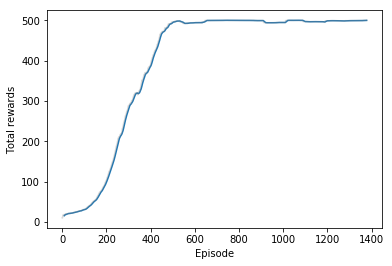

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

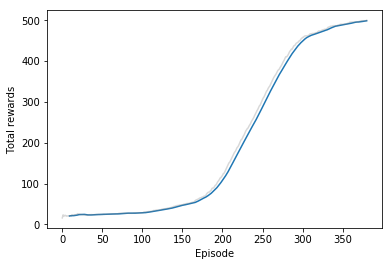

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

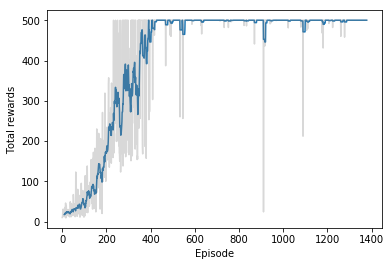

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

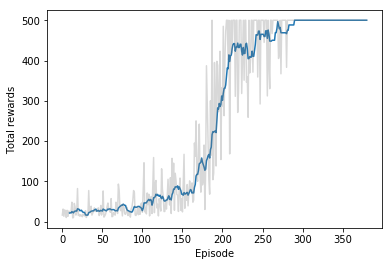

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.